In [16]:
import pandas as pd

path = "train_clean.jsonl"
path_test = "test_clean.jsonl"

df = pd.read_json(path, lines=True)
df_test = pd.read_json(path_test, lines=True)

In [22]:
df_test.dtypes

source                                                   object
in_reply_to_screen_name                                  object
is_quote_status                                            bool
possibly_sensitive                                      float64
truncated                                                  bool
user.listed_count                                         int64
user.favourites_count                                     int64
user.description                                         object
user.is_translator                                         bool
user.translator_type                                     object
user.geo_enabled                                           bool
user.profile_background_tile                               bool
user.statuses_count                                       int64
user.profile_use_background_image                          bool
user.default_profile                                       bool
user.location                           

In [18]:
set(df.columns) - set(df_test.columns)

{'label'}

In [19]:
cols_to_drop = [
    'text_clean',
    'user.description',
    'user.location',
    'created_at_dt',
    'in_reply_to_screen_name'
]

df_xgb = df.drop(columns=cols_to_drop)
df_t = df_test.drop(columns=cols_to_drop)

In [20]:
import pandas as pd

cat_cols = ['source', 'user.translator_type', 'quoted_status.lang']

for col in cat_cols:
    # 1) Build categories from train + test together
    all_cats = pd.concat([df_xgb[col], df_t[col]], axis=0).astype('category').cat.categories
    
    # 2) Create a shared categorical dtype
    cat_type = pd.api.types.CategoricalDtype(categories=all_cats)
    
    # 3) Apply this dtype to BOTH dataframes, then use .cat.codes
    df_xgb[col] = df_xgb[col].astype(cat_type).cat.codes
    df_t[col]   = df_t[col].astype(cat_type).cat.codes


In [23]:
y = df_xgb['label']
X = df_xgb.drop(columns=['label'])
X_test = df_t


In [24]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,        # 20% for validation
    stratify=y,           # keep same label proportion in train/valid
    random_state=42
)


In [25]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score
import pandas as pd

def modelfit(alg, X_train, y_train, X_valid, y_valid,
             useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    """
    Fit an XGBoost model with optional CV to tune n_estimators,
    then train on train set and evaluate on train + valid.
    Also plots CV AUC (if useTrainCV) and feature importance.
    """
    # ---------- STEP 1: CV with DMatrix to pick best n_estimators ----------
    if useTrainCV:
        print("Starting cross-validation with early stopping...")
        xgb_param = alg.get_xgb_params()
        
        # DMatrix for CV
        dtrain = xgb.DMatrix(X_train, label=y_train)
        
        cvresult = xgb.cv(
            params=xgb_param,
            dtrain=dtrain,
            num_boost_round=alg.get_params()['n_estimators'],
            nfold=cv_folds,
            metrics='auc',
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=True
        )
        
        # set best n_estimators
        best_n = cvresult.shape[0]
        alg.set_params(n_estimators=best_n)
        print(f"\nBest number of trees (n_estimators): {best_n}")
        
        # ---- Plot CV AUC over boosting rounds ----
        plt.figure(figsize=(7,4))
        plt.plot(cvresult['train-auc-mean'], label='train AUC')
        plt.plot(cvresult['test-auc-mean'], label='valid AUC')
        plt.xlabel("Boosting round")
        plt.ylabel("AUC")
        plt.title("XGBoost CV AUC")
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    # ---------- STEP 2: Fit on training set, evaluate on train + valid ----------
    print("\nFitting final model on training data...")
    alg.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        verbose=True
        # no eval_metric here → already set in constructor
        # you *could* add early_stopping_rounds=50 if your version supports it
    )
    
    # Predictions
    y_train_pred = alg.predict(X_train)
    y_train_proba = alg.predict_proba(X_train)[:, 1]
    
    y_valid_pred = alg.predict(X_valid)
    y_valid_proba = alg.predict_proba(X_valid)[:, 1]
    
    # Metrics
    print("\n=== Model Report (TRAIN) ===")
    print(f"Accuracy : {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"AUC      : {roc_auc_score(y_train, y_train_proba):.4f}")
    
    print("\n=== Model Report (VALID) ===")
    print(f"Accuracy : {accuracy_score(y_valid, y_valid_pred):.4f}")
    print(f"AUC      : {roc_auc_score(y_valid, y_valid_proba):.4f}")
    
    # ---------- STEP 3: Plot feature importance ----------
    booster = alg.get_booster()
    # importance_type can be: 'weight', 'gain', 'cover', etc.
    fmap = booster.get_score(importance_type='gain')
    
    if len(fmap) == 0:
        print("\nNo feature importance found (check model / training).")
        return alg
    
    # sort and keep top 20
    importance_df = pd.DataFrame(
        list(fmap.items()), columns=['feature', 'importance']
    ).sort_values('importance', ascending=False).head(20)
    
    plt.figure(figsize=(8, 6))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.gca().invert_yaxis()
    plt.xlabel("Gain")
    plt.title("Top 20 Feature Importances (gain)")
    plt.tight_layout()
    plt.show()
    
    return alg


In [34]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    learning_rate=0.05,
    n_estimators=1000,        # upper bound, CV will reduce this
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",       # set here (not in .fit)
    tree_method="hist",
    device="cuda"            # if this gives error, just remove this line
)


Starting cross-validation with early stopping...
[0]	train-auc:0.87453+0.00046	test-auc:0.87261+0.00161
[1]	train-auc:0.88770+0.00073	test-auc:0.88524+0.00174
[2]	train-auc:0.88105+0.00050	test-auc:0.87825+0.00193
[3]	train-auc:0.89107+0.00055	test-auc:0.88851+0.00155
[4]	train-auc:0.89476+0.00031	test-auc:0.89210+0.00147
[5]	train-auc:0.89846+0.00043	test-auc:0.89593+0.00121
[6]	train-auc:0.90029+0.00041	test-auc:0.89772+0.00101
[7]	train-auc:0.90034+0.00030	test-auc:0.89778+0.00105
[8]	train-auc:0.90143+0.00030	test-auc:0.89887+0.00094
[9]	train-auc:0.90220+0.00032	test-auc:0.89968+0.00093
[10]	train-auc:0.90272+0.00033	test-auc:0.90019+0.00085
[11]	train-auc:0.90317+0.00036	test-auc:0.90064+0.00084
[12]	train-auc:0.90343+0.00046	test-auc:0.90082+0.00088
[13]	train-auc:0.90377+0.00043	test-auc:0.90112+0.00089
[14]	train-auc:0.90390+0.00042	test-auc:0.90122+0.00092
[15]	train-auc:0.90424+0.00037	test-auc:0.90155+0.00089
[16]	train-auc:0.90449+0.00031	test-auc:0.90179+0.00094
[17]	trai

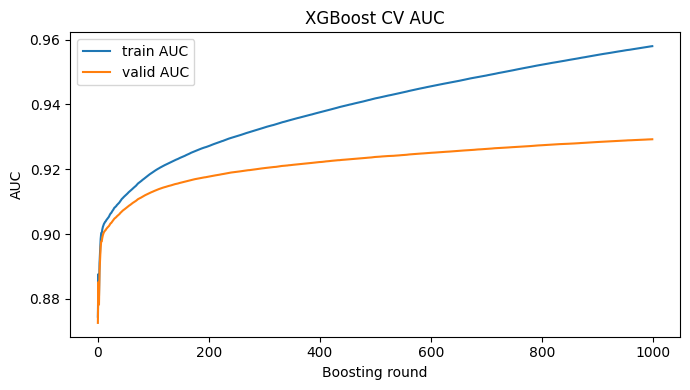


Fitting final model on training data...
[0]	validation_0-auc:0.87403	validation_1-auc:0.87396
[1]	validation_0-auc:0.88751	validation_1-auc:0.88665
[2]	validation_0-auc:0.88006	validation_1-auc:0.87927
[3]	validation_0-auc:0.89018	validation_1-auc:0.88921
[4]	validation_0-auc:0.89432	validation_1-auc:0.89330
[5]	validation_0-auc:0.89797	validation_1-auc:0.89719
[6]	validation_0-auc:0.90004	validation_1-auc:0.89905
[7]	validation_0-auc:0.89989	validation_1-auc:0.89874
[8]	validation_0-auc:0.90091	validation_1-auc:0.89975
[9]	validation_0-auc:0.90174	validation_1-auc:0.90056
[10]	validation_0-auc:0.90243	validation_1-auc:0.90127
[11]	validation_0-auc:0.90280	validation_1-auc:0.90169
[12]	validation_0-auc:0.90307	validation_1-auc:0.90189
[13]	validation_0-auc:0.90337	validation_1-auc:0.90227
[14]	validation_0-auc:0.90357	validation_1-auc:0.90243
[15]	validation_0-auc:0.90391	validation_1-auc:0.90277
[16]	validation_0-auc:0.90412	validation_1-auc:0.90296
[17]	validation_0-auc:0.90432	vali

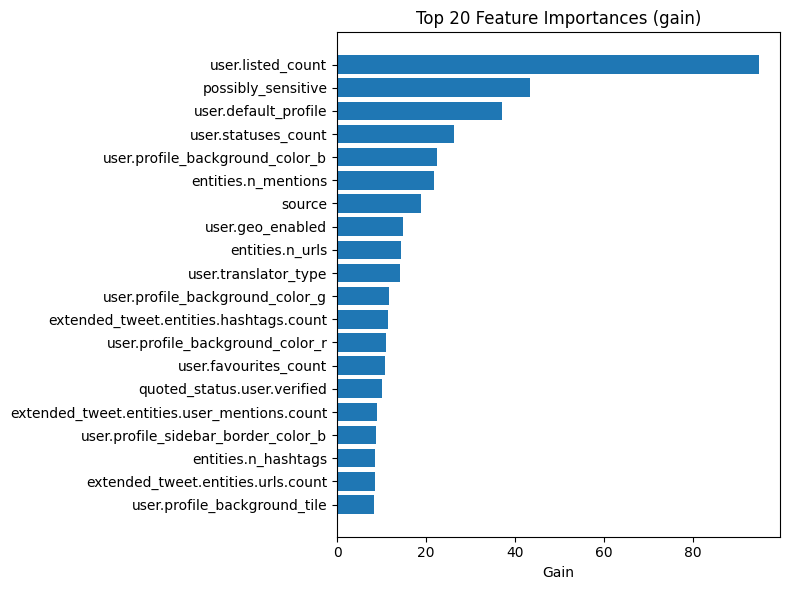

In [35]:
xgb_clf = modelfit(
    xgb_clf,
    X_train, y_train,
    X_valid, y_valid,
    useTrainCV=True,
    cv_folds=5,
    early_stopping_rounds=50
)


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [3, 5, 7],
    "min_child_weight": [1, 3, 5]
}
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,            # you can increase to 5 later
    verbose=2,
    n_jobs=-1        # use all cores
)
grid_search.fit(X_train, y_train)
print("Best params:", grid_search.best_params_)
print("Best AUC (cv):", grid_search.best_score_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [20:52:07] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ....................max_depth=3, min_child_weight=1; total time=  58.6s


/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [20:52:09] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ....................max_depth=3, min_child_weight=5; total time= 1.0min


/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [20:52:10] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [20:52:10] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data s

[CV] END ....................max_depth=3, min_child_weight=1; total time= 1.0min
[CV] END ....................max_depth=3, min_child_weight=3; total time= 1.0min


/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [20:52:10] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [20:52:10] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data s

[CV] END ....................max_depth=3, min_child_weight=3; total time= 1.0min
[CV] END ....................max_depth=3, min_child_weight=3; total time= 1.0min
[CV] END ....................max_depth=3, min_child_weight=5; total time= 1.0min
[CV] END ....................max_depth=3, min_child_weight=5; total time= 1.0min


/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [20:52:11] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ....................max_depth=3, min_child_weight=1; total time= 1.0min


/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [20:52:16] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ....................max_depth=5, min_child_weight=1; total time= 1.1min


/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [20:52:19] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [20:52:19] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data s

[CV] END ....................max_depth=5, min_child_weight=5; total time= 1.2min
[CV] END ....................max_depth=5, min_child_weight=1; total time= 1.2min
[CV] END ....................max_depth=5, min_child_weight=5; total time= 1.2min
[CV] END ....................max_depth=5, min_child_weight=3; total time= 1.2min
[CV] END ....................max_depth=5, min_child_weight=5; total time= 1.2min
[CV] END ....................max_depth=5, min_child_weight=1; total time= 1.2min


/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [20:52:19] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [20:52:19] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data s

[CV] END ....................max_depth=5, min_child_weight=3; total time= 1.2min
[CV] END ....................max_depth=5, min_child_weight=3; total time= 1.2min


/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [20:52:25] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [20:52:25] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data s

[CV] END ....................max_depth=7, min_child_weight=5; total time= 1.3min
[CV] END ....................max_depth=7, min_child_weight=5; total time= 1.3min
[CV] END ....................max_depth=7, min_child_weight=5; total time= 1.3min


/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [20:52:25] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [20:52:25] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data s

[CV] END ....................max_depth=7, min_child_weight=3; total time= 1.3min
[CV] END ....................max_depth=7, min_child_weight=3; total time= 1.3min
[CV] END ....................max_depth=7, min_child_weight=1; total time= 1.3min


/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [20:52:26] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [20:52:26] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data s

[CV] END ....................max_depth=7, min_child_weight=1; total time= 1.3min
[CV] END ....................max_depth=7, min_child_weight=3; total time= 1.3min
[CV] END ....................max_depth=7, min_child_weight=1; total time= 1.3min
Best params: {'max_depth': 7, 'min_child_weight': 1}
Best AUC (cv): 0.9319040868783003


In [38]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [8,9,10]
}
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,            # you can increase to 5 later
    verbose=2,
    n_jobs=-1        # use all cores
)
grid_search.fit(X_train, y_train)
print("Best params:", grid_search.best_params_)
print("Best AUC (cv):", grid_search.best_score_)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ........................................max_depth=8; total time=  55.5s
[CV] END ........................................max_depth=8; total time=  55.7s
[CV] END ........................................max_depth=8; total time=  55.7s
[CV] END ........................................max_depth=9; total time=  59.3s
[CV] END ........................................max_depth=9; total time=  59.4s
[CV] END ........................................max_depth=9; total time=  59.4s
[CV] END .......................................max_depth=10; total time= 1.0min
[CV] END .......................................max_depth=10; total time= 1.0min
[CV] END .......................................max_depth=10; total time= 1.0min
Best params: {'max_depth': 10}
Best AUC (cv): 0.9411190214070643


In [40]:
from xgboost import XGBClassifier

xgb_gamma_base = XGBClassifier(
    learning_rate=0.05,
    n_estimators=1000,                 # keep fixed for this search
    max_depth=10,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    device="cuda"                     # remove if no GPU
)

In [42]:
from sklearn.model_selection import GridSearchCV

param_grid_gamma = {
    "gamma": [0, 0.1, 0.3, 0.5, 1]
}
grid_search_gamma = GridSearchCV(
    estimator=xgb_gamma_base,
    param_grid=param_grid_gamma,
    scoring="roc_auc",
    cv=3,          # you can make it 5 later if not too slow
    verbose=2,
    n_jobs=-1
)

grid_search_gamma.fit(X_train, y_train)

print("Best params (gamma):", grid_search_gamma.best_params_)
print("Best AUC (cv):", grid_search_gamma.best_score_)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [21:04:07] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [21:04:07] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data s

[CV] END ............................................gamma=1; total time= 1.6min
[CV] END ............................................gamma=1; total time= 1.6min


/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [21:04:07] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ............................................gamma=1; total time= 1.6min


/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [21:04:25] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ..........................................gamma=0.5; total time= 1.9min


/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [21:04:26] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [21:04:26] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data s

[CV] END ..........................................gamma=0.5; total time= 1.9min
[CV] END ..........................................gamma=0.5; total time= 1.9min


/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [21:04:29] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ..........................................gamma=0.3; total time= 1.9min


/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [21:04:29] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ..........................................gamma=0.3; total time= 1.9min


/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [21:04:30] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [21:04:30] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data s

[CV] END ..........................................gamma=0.3; total time= 1.9min
[CV] END ..........................................gamma=0.1; total time= 1.9min
[CV] END ..........................................gamma=0.1; total time= 1.9min
[CV] END ............................................gamma=0; total time= 1.9min
[CV] END ..........................................gamma=0.1; total time= 1.9min
[CV] END ............................................gamma=0; total time= 1.9min
[CV] END ............................................gamma=0; total time= 1.9min
Best params (gamma): {'gamma': 0}
Best AUC (cv): 0.9411190214070643


In [47]:
best_max_depth = 10
best_min_child_weight = 1
best_gamma = 0

from xgboost import XGBClassifier

xgb_best_so_far = XGBClassifier(
    learning_rate=0.05,
    n_estimators=1000,                # still fixed for now
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    gamma=best_gamma,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    device="cuda"                    # remove if no GPU
)


In [48]:
from sklearn.model_selection import GridSearchCV

param_grid_sub = {
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

grid_search_sub = GridSearchCV(
    estimator=xgb_best_so_far,
    param_grid=param_grid_sub,
    scoring="roc_auc",
    cv=3,          # or 5 if not too slow
    verbose=2,
    n_jobs=-1
)

grid_search_sub.fit(X_train, y_train)

print("Best params (subsample/colsample_bytree):", grid_search_sub.best_params_)
print("Best AUC (cv):", grid_search_sub.best_score_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [21:24:13] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ................colsample_bytree=1.0, subsample=1.0; total time= 3.6min


/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [21:24:14] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [21:24:14] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data s

[CV] END ................colsample_bytree=1.0, subsample=1.0; total time= 3.6min
[CV] END ................colsample_bytree=1.0, subsample=1.0; total time= 3.6min


/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [21:24:16] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ................colsample_bytree=1.0, subsample=0.8; total time= 3.7min


/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [21:24:16] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [21:24:17] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data s

[CV] END ................colsample_bytree=1.0, subsample=0.8; total time= 3.7min
[CV] END ................colsample_bytree=1.0, subsample=0.8; total time= 3.7min
[CV] END ................colsample_bytree=1.0, subsample=0.6; total time= 3.7min
[CV] END ................colsample_bytree=1.0, subsample=0.6; total time= 3.7min


/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [21:24:17] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ................colsample_bytree=1.0, subsample=0.6; total time= 3.7min


/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [21:24:25] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ................colsample_bytree=0.6, subsample=1.0; total time= 3.8min


/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [21:24:26] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [21:24:26] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data s

[CV] END ................colsample_bytree=0.8, subsample=1.0; total time= 3.8min
[CV] END ................colsample_bytree=0.6, subsample=0.6; total time= 3.8min


/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [21:24:27] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [21:24:27] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data s

[CV] END ................colsample_bytree=0.6, subsample=1.0; total time= 3.9min
[CV] END ................colsample_bytree=0.6, subsample=1.0; total time= 3.9min


/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [21:24:27] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [21:24:27] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data s

[CV] END ................colsample_bytree=0.8, subsample=1.0; total time= 3.9min
[CV] END ................colsample_bytree=0.8, subsample=1.0; total time= 3.9min


/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [21:24:28] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [21:24:28] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data s

[CV] END ................colsample_bytree=0.8, subsample=0.6; total time= 3.9min
[CV] END ................colsample_bytree=0.6, subsample=0.8; total time= 3.9min
[CV] END ................colsample_bytree=0.6, subsample=0.8; total time= 3.9min
[CV] END ................colsample_bytree=0.8, subsample=0.8; total time= 3.9min
[CV] END ................colsample_bytree=0.8, subsample=0.8; total time= 3.9min
[CV] END ................colsample_bytree=0.8, subsample=0.6; total time= 3.9min


/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [21:24:28] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [21:24:28] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data s

[CV] END ................colsample_bytree=0.6, subsample=0.8; total time= 3.9min
[CV] END ................colsample_bytree=0.6, subsample=0.6; total time= 3.9min
[CV] END ................colsample_bytree=0.8, subsample=0.8; total time= 3.9min
[CV] END ................colsample_bytree=0.8, subsample=0.6; total time= 3.9min
[CV] END ................colsample_bytree=0.6, subsample=0.6; total time= 3.9min
Best params (subsample/colsample_bytree): {'colsample_bytree': 0.6, 'subsample': 1.0}
Best AUC (cv): 0.9442930940461491


In [49]:

xgb_best_so_far = XGBClassifier(
    learning_rate=0.05,
    n_estimators=1000,                # still fixed for now
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    gamma=best_gamma,
    subsample=1,
    colsample_bytree=0.6,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    device="cuda"                    # remove if no GPU
)


In [50]:
from sklearn.model_selection import GridSearchCV

param_grid_reg = {
    "reg_alpha":  [0, 0.001, 0.01, 0.1, 1],
    "reg_lambda": [0.1, 1, 5, 10]
}
grid_search_reg = GridSearchCV(
    estimator=xgb_best_so_far,
    param_grid=param_grid_reg,
    scoring="roc_auc",
    cv=3,          # 3-fold CV to save time
    verbose=2,
    n_jobs=-1
)

grid_search_reg.fit(X_train, y_train)

print("Best params (reg):", grid_search_reg.best_params_)
print("Best AUC (cv):", grid_search_reg.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END ..........................reg_alpha=0, reg_lambda=5; total time= 3.5min
[CV] END ..........................reg_alpha=0, reg_lambda=1; total time= 3.5min
[CV] END .........................reg_alpha=0, reg_lambda=10; total time= 3.5min
[CV] END ..........................reg_alpha=0, reg_lambda=5; total time= 3.5min
[CV] END ......................reg_alpha=0.001, reg_lambda=5; total time= 3.5min
[CV] END .....................reg_alpha=0.001, reg_lambda=10; total time= 3.5min
[CV] END ..........................reg_alpha=0, reg_lambda=1; total time= 3.6min
[CV] END .....................reg_alpha=0.001, reg_lambda=10; total time= 3.6min
[CV] END ..........................reg_alpha=0, reg_lambda=1; total time= 3.6min
[CV] END .........................reg_alpha=0, reg_lambda=10; total time= 3.6min
[CV] END ......................reg_alpha=0.001, reg_lambda=1; total time= 3.6min
[CV] END .........................reg_alpha=0, r

/users/eleves-b/2025/sarah.rouphael/miniconda3/envs/deep/lib/python3.11/site-packages/xgboost/core.py:774: UserWarning: [21:28:57] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ........................reg_alpha=0, reg_lambda=0.1; total time= 3.6min
[CV] END .......................reg_alpha=0.01, reg_lambda=5; total time= 3.7min
[CV] END ......................reg_alpha=0.01, reg_lambda=10; total time= 3.7min
[CV] END ........................reg_alpha=0.1, reg_lambda=5; total time= 3.7min
[CV] END .......................reg_alpha=0.01, reg_lambda=1; total time= 3.8min
[CV] END .......................reg_alpha=0.01, reg_lambda=5; total time= 3.8min
[CV] END ......................reg_alpha=0.01, reg_lambda=10; total time= 3.7min
[CV] END .......................reg_alpha=0.01, reg_lambda=1; total time= 3.8min
[CV] END .......................reg_alpha=0.1, reg_lambda=10; total time= 3.7min
[CV] END ........................reg_alpha=0.1, reg_lambda=5; total time= 3.8min
[CV] END ......................reg_alpha=0.01, reg_lambda=10; total time= 3.8min
[CV] END .......................reg_alpha=0.1, reg_lambda=10; total time= 3.7min
[CV] END ...................

In [52]:
xgb_best_so_far = XGBClassifier(
    learning_rate=0.05,
    n_estimators=1000,                # still fixed for now
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    gamma=best_gamma,
    subsample=1,
    reg_alpha=0.1, reg_lambda=0.1,
    colsample_bytree=0.6,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    device="cuda"                    # remove if no GPU
)

Starting cross-validation with early stopping...
[0]	train-auc:0.89738+0.00055	test-auc:0.88021+0.00107
[1]	train-auc:0.91471+0.00032	test-auc:0.89563+0.00151
[2]	train-auc:0.91355+0.00046	test-auc:0.89317+0.00202
[3]	train-auc:0.90993+0.00044	test-auc:0.88803+0.00200
[4]	train-auc:0.92021+0.00048	test-auc:0.90044+0.00167
[5]	train-auc:0.92627+0.00048	test-auc:0.90768+0.00159
[6]	train-auc:0.92581+0.00045	test-auc:0.90616+0.00168
[7]	train-auc:0.92772+0.00047	test-auc:0.90847+0.00153
[8]	train-auc:0.92823+0.00047	test-auc:0.90934+0.00151
[9]	train-auc:0.92892+0.00047	test-auc:0.90929+0.00147
[10]	train-auc:0.92876+0.00042	test-auc:0.90885+0.00144
[11]	train-auc:0.93127+0.00042	test-auc:0.91197+0.00149
[12]	train-auc:0.93145+0.00042	test-auc:0.91168+0.00157
[13]	train-auc:0.93310+0.00040	test-auc:0.91376+0.00159
[14]	train-auc:0.93360+0.00040	test-auc:0.91444+0.00154
[15]	train-auc:0.93380+0.00041	test-auc:0.91462+0.00155
[16]	train-auc:0.93388+0.00040	test-auc:0.91436+0.00159
[17]	trai

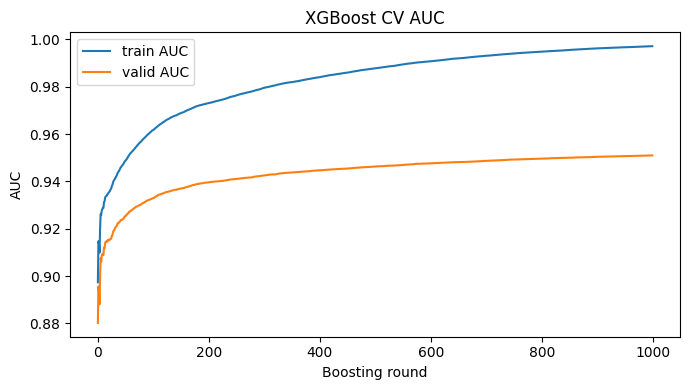


Fitting final model on training data...
[0]	validation_0-auc:0.89562	validation_1-auc:0.88219
[1]	validation_0-auc:0.91272	validation_1-auc:0.89820
[2]	validation_0-auc:0.91188	validation_1-auc:0.89567
[3]	validation_0-auc:0.90787	validation_1-auc:0.89023
[4]	validation_0-auc:0.91844	validation_1-auc:0.90278
[5]	validation_0-auc:0.92442	validation_1-auc:0.91032
[6]	validation_0-auc:0.92384	validation_1-auc:0.90860
[7]	validation_0-auc:0.92579	validation_1-auc:0.91064
[8]	validation_0-auc:0.92636	validation_1-auc:0.91151
[9]	validation_0-auc:0.92703	validation_1-auc:0.91171
[10]	validation_0-auc:0.92678	validation_1-auc:0.91120
[11]	validation_0-auc:0.92935	validation_1-auc:0.91443
[12]	validation_0-auc:0.92944	validation_1-auc:0.91421
[13]	validation_0-auc:0.93112	validation_1-auc:0.91619
[14]	validation_0-auc:0.93159	validation_1-auc:0.91688
[15]	validation_0-auc:0.93180	validation_1-auc:0.91700
[16]	validation_0-auc:0.93184	validation_1-auc:0.91657
[17]	validation_0-auc:0.93254	vali

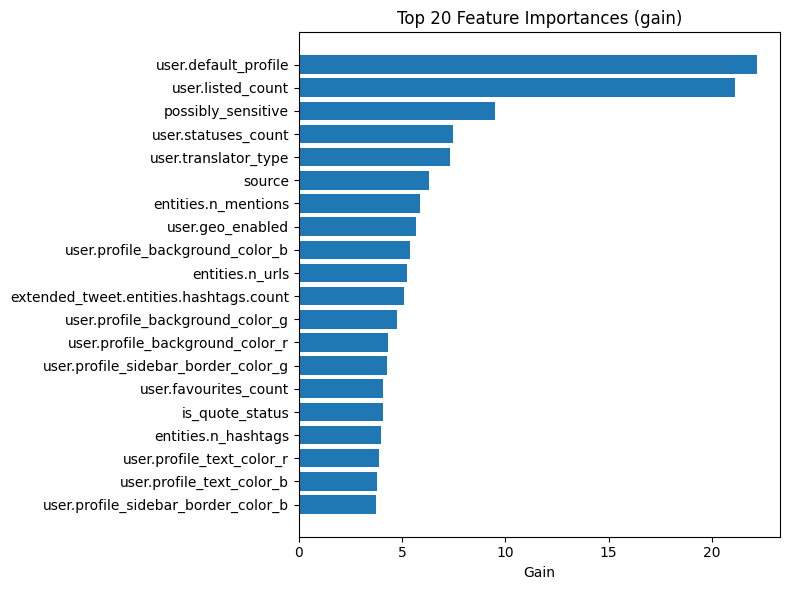

In [53]:
xgb_clf = modelfit(
    xgb_best_so_far,
    X_train, y_train,
    X_valid, y_valid,
    useTrainCV=True,
    cv_folds=5,
    early_stopping_rounds=50
)


In [54]:
import pandas as pd

# 1) Make sure test features have same columns & order as train
X_test = df_t[X.columns]   # X is the features you used for training

# 2) Predict probabilities for class 1 (Influencer)
y_test_proba = xgb_clf.predict_proba(X_test)[:, 1]

# 3) Build submission dataframe
submission = pd.DataFrame({
    "ID": range(len(X_test)),   # or df_t.index if you prefer
    "Predicted": y_test_proba
})

# 4) Save to CSV
submission.to_csv("xgb_test_prob_predictions.csv", index=False)

submission.head()


,ID,Predicted
0,0,0.993133
1,1,0.999828
2,2,0.148326
3,3,0.780604
4,4,0.024818


In [56]:
y_test_pred = xgb_clf.predict(X_test)   # this should already be 0/1

submission = pd.DataFrame({
    "ID": range(len(X_test)),   # or df_t.index if you prefer
    "Predicted": y_test_pred
})

submission.to_csv("xgb_test_predictions.csv", index=False)
submission.head()


,ID,Predicted
0,0,1
1,1,1
2,2,0
3,3,1
4,4,0
